# Pretrained Network Cats and Dog Classification

### Using a Pretrained Convnet

A common and highly effective approach to deep learning on small image datasets is to use a pretrained network. A **pretrained network** is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. If this original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world, and hence its features can prove useful for many different computervision problems, even though these new problems may involve completely different classes than those of the original task. For instance, you might train a network on ImageNet (where classes are mostly animals and everyday objects) and then repurpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older, shallow-learning approaches, and it makes deep learning very effective for small-data problems.

In this case, let’s consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1,000 different classes). ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to
perform well on the dogs-versus-cats classification problem.

We’ll use the ```VGG16``` architecture, it’s a simple and widely used convnet architecture for ImageNet. Although it’s an older model, far from the current state of the art and somewhat heavier than many other recent models, I chose it because its architecture is similar to what we’re already familiar with and is easy to understand without introducing any new concepts. This may be our first encounter with one of these cutesy model names—VGG, ResNet, Inception, Inception-ResNet, Xception, and so on; we’ll get used to them, because they will come up frequently if we keep doing deep learning for computer vision.

There are two ways to use a pretrained network: **feature extraction** and **fine-tuning**.

Let’s start with feature extraction.

### Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

As we saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely connected classifier. The first part is called the **convolutional base** of the model. In the case of convnets, feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output.

![capture](https://user-images.githubusercontent.com/13174586/49786736-cb98dc00-fd4a-11e8-99f1-14210e197da4.JPG)

Why only reuse the convolutional base? Could we reuse the densely connected classifier as well? In general, doing so should be avoided. The reason is that the representations learned by the convolutional base are likely to be more generic and therefore
more reusable: the feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer-vision problem at hand. But the representations learned by the classifier will necessarily be specific to the set of classes on which the model was trained—they will only contain information about the presence probability of this or that class in the entire picture. Additionally, representations found in densely connected layers no longer contain any information about where objects are located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely connected features are largely useless. 

The level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), whereas layers that are higher up extract more-abstract concepts (such as “cat ear” or “dog eye”). So if our new dataset differs a lot from the dataset on which the original model was trained, we may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

In this case, because the ImageNet class set contains multiple dog and cat classes, it’s likely to be beneficial to reuse the information contained in the densely connected layers of the original model. But we’ll choose not to, in order to cover the more general case where the class set of the new problem doesn’t overlap the class set of the original model. Let’s put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from cat and dog images, and then train a dogs-versus-cats classifier on top of these features.

The VGG16 model, among others, comes prepackaged with Keras. We can import it from the keras.applications module. Here’s the list of image-classification models (all pretrained on the ImageNet dataset) that are available as part of ```keras.applications```:
 - ```Xception```
 - ```Inception V3```
 - ```ResNet50```
 - ```VGG16```
 - ```VGG19```
 - ```MobileNet```
 


#### Instantiate The ```VGG16``` Convolutional Base

In [21]:
from keras.applications import VGG16

conv_base= VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

We pass three arguments to the constructor:
 - **weights** specifies the weight checkpoint from which to initialize the model.
 - **include_top** refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because we intend to use our own densely connected classifier (with only two classes: cat and dog), we don’t need to include it.
 - **input_shape** is the shape of the image tensors that we’ll feed to the network.This argument is purely optional: if we don’t pass it, the network will be able to process inputs of any size.

Here’s the detail of the architecture of the ```VGG16``` convolutional base. It’s similar to the simple convnets we’re already familiar with:

In [22]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

The final feature map has shape (4, 4, 512). That’s the feature on top of which we’ll stick a densely connected classifier. At this point, there are two ways we could proceed:
 - Running the convolutional base over your dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow us to use data augmentation.
 - Extending the model we have (```conv_base```) by adding ```Dense``` layers on top, and running the whole thing end to end on the input data. This will allow us to use data augmentation, because every input image goes through the convolutional base every time it’s seen by the model. But for the same reason, this technique is far more expensive than the first.
 
Let’s walk through the code required to set up the first one: recording the output of ```conv_base``` on our data and using these outputs as inputs to a new model.

#### FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION
We’ll start by running instances of the previously introduced ```ImageDataGenerator``` to extract images as Numpy arrays as well as their labels. We’ll extract features from these images by calling the predict method of the ```conv_base``` model.

#### Extract Features Using The Pretrained Convolutional Base

In [1]:
import os
import numpy as np
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
base_dir= 'C:/Users/soumyama/Documents/Python Scripts/Keras/Cat_Dog/data'
train_dir= os.path.join(base_dir, 'train')
validation_dir= os.path.join(base_dir, 'validation')
test_dir= os.path.join(base_dir, 'test')

In [3]:
datagen= ImageDataGenerator(rescale=1./255)
batch_size=20

In [4]:
def extract_features(directory, sample_count):
    features= np.zeros(shape=(sample_count, 4,4, 512))
    labels= np.zeros(shape=(sample_count))
    generator= datagen.flow_from_directory(directory,
                                          target_size=(150,150),
                                          batch_size=batch_size,
                                          class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch= conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size]= features_batch
        labels[i*batch_size:(i+1)*batch_size]= labels_batch
        i+=1
        if i *batch_size>= sample_count:
            break
    return features, labels

In [27]:
train_features, train_labels= extract_features(train_dir, 2000)
validation_features, validation_labels= extract_features(validation_dir, 1000)
test_features, test_labels= extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [28]:
train_features.shape

(2000, 4, 4, 512)

In [29]:
train_labels.shape

(2000,)

The extracted features are currently of shape ```(samples, 4, 4, 512)```. We’ll feed them to a densely connected classifier, so first we must flatten them to ```(samples, 8192)```:

In [30]:
train_features= train_features.reshape(2000, 4*4*512)
validation_features= validation_features.reshape(1000, 4*4*512)
test_features= test_features.reshape(1000, 4*4*512)

At this point, we can define our densely connected classifier (note the use of dropout for regularization) and train it on the data and labels that we just recorded.

#### Define And Train The Densely Connected Classifier

In [31]:
model= models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [32]:
model.compile(optimizer= optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

In [33]:
history= model.fit(train_features, train_labels, epochs=30, batch_size=20, 
                   validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 463us/step - loss: 0.5977 - acc: 0.6650 - val_loss: 0.4440 - val_acc: 0.8290
Epoch 2/30
2000/2000 [==============================] - 1s 297us/step - loss: 0.4321 - acc: 0.8015 - val_loss: 0.3615 - val_acc: 0.8570
Epoch 3/30
2000/2000 [==============================] - 1s 292us/step - loss: 0.3487 - acc: 0.8570 - val_loss: 0.3172 - val_acc: 0.8800
Epoch 4/30
2000/2000 [==============================] - 1s 292us/step - loss: 0.3058 - acc: 0.8710 - val_loss: 0.2958 - val_acc: 0.8790
Epoch 5/30
2000/2000 [==============================] - 1s 290us/step - loss: 0.2845 - acc: 0.8880 - val_loss: 0.2837 - val_acc: 0.8900
Epoch 6/30
2000/2000 [==============================] - 1s 292us/step - loss: 0.2657 - acc: 0.8940 - val_loss: 0.2709 - val_acc: 0.8910
Epoch 7/30
2000/2000 [==============================] - 1s 357us/step - loss: 0.2500 - acc: 0.8995 - val_loss: 0.2634 - val_acc: 0.8930


Training is very fast, because we only have to deal with two Dense layers—an epoch takes less than one second even on CPU.

Let’s look at the loss and accuracy curves during training

#### Plot the results

In [34]:
acc= history.history['acc']
val_acc= history.history['val_acc']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs= range(1, len(acc)+1)

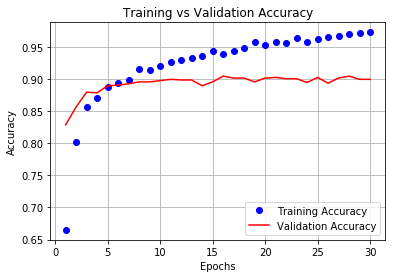

In [35]:
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', color= 'red', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

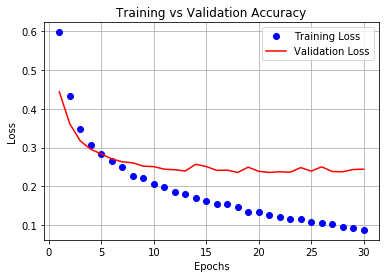

In [36]:
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', color= 'red', label='Validation Loss')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

We reach a validation accuracy of ~90% — much better than we achieved in the previous section with the small model trained from scratch. But the plots also indicate that we’re overfitting almost from the start—despite using dropout with a fairly large rate. That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets.


#### FEATURE EXTRACTION WITH DATA AUGMENTATION

Let’s review the second technique for doing feature extraction, which is much slower and more expensive, but which allows us to use data augmentation during training: extending the `conv_base` model and running it end to end on the inputs.

> **NOTE** This technique is so expensive that we should only attempt it if we have access to a GPU—it’s absolutely intractable on CPU.

Because models behave just like layers, we can add a model (like ```conv_base```) to a ```Sequential``` model just like we would add a layer.


#### Adding a Densely Connected Classifier on Top of The Convolutional Base

In [5]:
from keras import models
from keras import layers
from keras.applications import VGG16

conv_base= VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

model= models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


As we can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we’re adding on top has 2 million parameters. 

Before we compile and train the model, it’s very important to freeze the convolutional base. **Freezing** a layer or set of layers means preventing their weights from being updated during training. If we don’t do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the ```Dense``` layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.
In Keras, we freeze a network by setting its **trainable** attribute to ```False```:

In [11]:
print("Number of Trainable weights before freezing:", len(model.trainable_weights))
conv_base.trainable=False
print("Number of Trainable weights after freezing:", len(model.trainable_weights))

Number of Trainable weights before freezing: 30
Number of Trainable weights after freezing: 4


With this setup, only the weights from the two Dense layers that we added will be trained. That’s a total of four weight tensors: two per layer (the main weight matrix
and the bias vector). Note that in order for these changes to take effect, we must first compile the model. If wew ever modify weight trainability after compilation, you
should then recompile the model, or these changes will be ignored.

Now we can start training your model, with the data-augmentation configuration.

#### Train The Model End To End With a Frozen Convolutional Base

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen= ImageDataGenerator(rescale=1./255,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

test_datagen= ImageDataGenerator(rescale=1./255) #validation data shouldn’t be augmented!

train_generator= train_datagen.flow_from_directory(train_dir,
                                                  target_size=(150,150),
                                                  batch_size=20,
                                                  class_mode='binary')

validation_generator= test_datagen.flow_from_directory(validation_dir,
                                                  target_size=(150,150),
                                                  batch_size=20,
                                                  class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

In [14]:
history= model.fit_generator(train_generator, steps_per_epoch=100, epochs=50, 
                   validation_data=validation_generator, validation_steps=50)

Epoch 1/50
100/100 [==============================] - 38s 379ms/step - loss: 0.5884 - acc: 0.7005 - val_loss: 0.4635 - val_acc: 0.8320
Epoch 2/50
100/100 [==============================] - 36s 359ms/step - loss: 0.4776 - acc: 0.7860 - val_loss: 0.3771 - val_acc: 0.8640
Epoch 3/50
100/100 [==============================] - 36s 360ms/step - loss: 0.4420 - acc: 0.8015 - val_loss: 0.3401 - val_acc: 0.8700
Epoch 4/50
100/100 [==============================] - 36s 360ms/step - loss: 0.4095 - acc: 0.8270 - val_loss: 0.3162 - val_acc: 0.8800
Epoch 5/50
100/100 [==============================] - 36s 360ms/step - loss: 0.3852 - acc: 0.8340 - val_loss: 0.3022 - val_acc: 0.8830
Epoch 6/50
100/100 [==============================] - 36s 360ms/step - loss: 0.3683 - acc: 0.8390 - val_loss: 0.2883 - val_acc: 0.8940
Epoch 7/50
100/100 [==============================] - 36s 360ms/step - loss: 0.3697 - acc: 0.8360 - val_loss: 0.2799 - val_acc: 0.8930
Epoch 8/50
100/100 [==============================] - 3

Let’s plot the results again. We reached a validation accuracy of ~90%. This is much better than we achieved with the small
convnet trained from scratch. Though the model is suffering from **underfitting**.

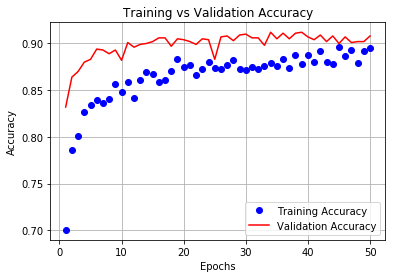

In [18]:
import matplotlib.pyplot as plt

acc= history.history['acc']
val_acc= history.history['val_acc']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs= range(1, len(acc)+1)


plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', color='red', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

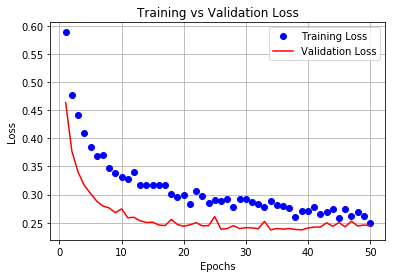

In [19]:
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

### Fine-tuning
Another widely used technique for model reuse, complementary to feature extraction, is **fine-tuning**. Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers. This is called **fine-tuning** because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.
![capture](https://user-images.githubusercontent.com/13174586/49849382-44f20680-fdff-11e8-9808-1ec8a749c79f.JPG)
As stated earlier that it’s necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. For the same reason, it’s only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classifier isn’t already trained, then the error signal propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed. Thus the steps for fine-tuning a network are as follows:
 - Add custom network on top of an already-trained base network.
 - Freeze the base network.
 - Train the part we added.
 - Unfreeze some layers in the base network.
 - Jointly train both these layers and the part we added.

We already completed the first three steps when doing feature extraction. Let’s proceed with step 4: we’ll unfreeze our ```conv_base``` and then freeze individual layers inside it.

In [58]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

We’ll fine-tune the last three convolutional layers, which means all layers up to ```block4_pool``` should be frozen, and the layers ```block5_conv1```, ```block5_conv2```, and ```block5_conv3``` should be trainable. 

*Why not fine-tune more layers? Why not fine-tune the entire convolutional base?* We could. But we need to consider the following: 
 - Earlier layers in the convolutional base encode more-generic, reusable features, whereas layers higher up encode more-specialized features. It’s more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on your new problem. There would be fast-decreasing returns in fine-tuning lower layers.
 - The more parameters you’re training, the more you’re at risk of overfitting. The convolutional base has 15 million parameters, so it would be risky to attempt to train it on your small dataset.
 
Thus, in this situation, it’s a good strategy to fine-tune only the top two or three layers in the convolutional base.

#### Freeze All Layers Up To a Specific One

In [7]:
conv_base.trainable=True

set_trainable=False
for layer in conv_base.layers:
    if layer.name== 'block5_conv1':
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else: 
        layer.trainable=False

Now we can begin fine-tuning the network. We’ll do this with the ```RMSProp``` optimizer, using a **very low learning rate**. The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the three layers we’re fine-tuning. Updates that are too large may harm these representations.

#### Fine-tuning The Model

In [8]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5), loss='binary_crossentropy', metrics=['acc'])

In [9]:
history=model.fit_generator(train_generator, steps_per_epoch=100, epochs=30,
                   validation_data=validation_generator, validation_steps=50)

Epoch 1/30
100/100 [==============================] - 42s 416ms/step - loss: 0.5549 - acc: 0.7185 - val_loss: 0.3912 - val_acc: 0.8260
Epoch 2/30
100/100 [==============================] - 39s 392ms/step - loss: 0.3862 - acc: 0.8260 - val_loss: 0.2768 - val_acc: 0.8820
Epoch 3/30
100/100 [==============================] - 39s 393ms/step - loss: 0.3124 - acc: 0.8605 - val_loss: 0.2280 - val_acc: 0.8990
Epoch 4/30
100/100 [==============================] - 39s 394ms/step - loss: 0.2973 - acc: 0.8760 - val_loss: 0.2101 - val_acc: 0.9090
Epoch 5/30
100/100 [==============================] - 39s 394ms/step - loss: 0.2735 - acc: 0.8880 - val_loss: 0.1989 - val_acc: 0.9120
Epoch 6/30
100/100 [==============================] - 39s 393ms/step - loss: 0.2554 - acc: 0.8915 - val_loss: 0.1888 - val_acc: 0.9180
Epoch 7/30
100/100 [==============================] - 40s 395ms/step - loss: 0.2287 - acc: 0.9085 - val_loss: 0.1791 - val_acc: 0.9230
Epoch 8/30
100/100 [==============================] - 4

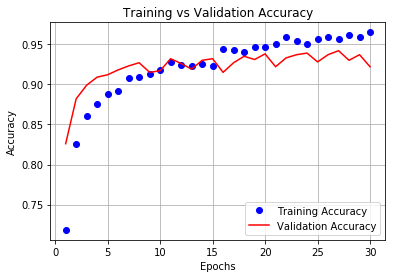

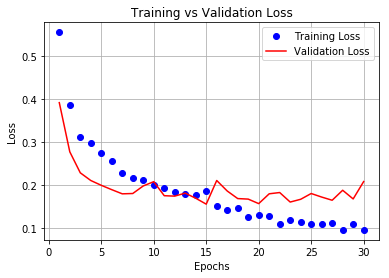

In [10]:
import matplotlib.pyplot as plt

acc= history.history['acc']
val_acc= history.history['val_acc']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs= range(1, len(acc)+1)


plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', color='red', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

These curves look noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving averages of these quantities.
Here’s a trivial utility function to do this:

#### Smooth The Plots

In [11]:
def smooth_curve(points, factor=0.8):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous=smoothed_points[-1]
            smoothed_points.append(previous*factor +point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

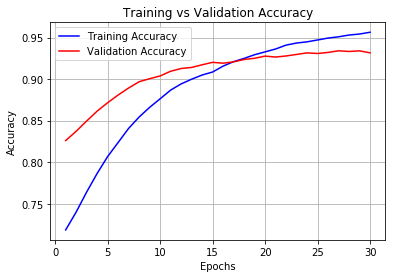

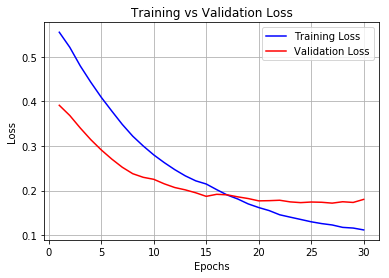

In [12]:
plt.plot(epochs, smooth_curve(acc), 'b', label='Training Accuracy')
plt.plot(epochs, smooth_curve(val_acc), 'b', color='red', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.plot(epochs, smooth_curve(loss), 'b', label='Training Loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', color='red', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

The validation accuracy curve look much cleaner. We’re seeing a nice 1% absolute improvement in accuracy, from about 92% to above 93%.

Note that the loss curve doesn’t show any real improvement (in fact, it’s deteriorating). We may wonder, how could accuracy stay stable or improve if the loss isn’t decreasing? The answer is simple: what we display is an average of pointwise loss values;
but what matters for accuracy is the distribution of the loss values, not their average, because accuracy is the result of a binary thresholding of the class probability predicted by the model. The model may still be improving even if this isn’t reflected in the average loss.

We can now finally evaluate this model on the test data:

In [16]:
test_generator= test_datagen.flow_from_directory(test_dir,
                                  target_size=(150,150),
                                  batch_size=20,
                                  class_mode='binary')

Found 1000 images belonging to 2 classes.


In [17]:
test_loss, test_acc= model.evaluate_generator(test_generator, steps=50)
print(test_loss, test_acc)

0.22912940839771181 0.9329999947547912


Here we get a test accuracy of 93%

#### Predict The Output on Test Data

In [18]:
model.predict_generator(test_generator, steps=1)

array([[6.4050496e-01],
       [1.0269343e-01],
       [9.9990511e-01],
       [9.9984431e-01],
       [9.9965286e-01],
       [1.7661676e-04],
       [1.5044876e-02],
       [1.9062331e-04],
       [2.8523136e-05],
       [1.1864670e-03],
       [9.9989855e-01],
       [9.9416047e-01],
       [2.8719911e-02],
       [5.4645066e-06],
       [5.9861869e-01],
       [9.9988818e-01],
       [9.2738408e-01],
       [9.9999988e-01],
       [9.8095417e-01],
       [8.5098580e-02]], dtype=float32)

In [19]:
base_dir= 'C:/Users/soumyama/Documents/Python Scripts/Keras/Cat_Dog/data'
final_test_dir= os.path.join(base_dir, 'Final_Test')
os.listdir(final_test_dir)

['test']

In [20]:
datagen= ImageDataGenerator(rescale=1./255)
final_test_generator= datagen.flow_from_directory(
        final_test_dir,
        target_size=(150,150),
        batch_size=20,
        class_mode='binary')

Found 12500 images belonging to 1 classes.


In [21]:
op=model.predict_generator(final_test_generator, steps=625,verbose=1)

625/625 [==============================] - 144s 231ms/step


In [22]:
print(op[:10])
print(len(op))

[[1.00000000e+00]
 [9.99999523e-01]
 [9.64828610e-01]
 [9.99846220e-01]
 [9.99999881e-01]
 [9.99992728e-01]
 [3.32855125e-05]
 [1.00000000e+00]
 [1.01234615e-02]
 [3.67465800e-05]]
12500


##### Cat: 0 Dog: 1